# Practical Deep Learning Workshop 2021
## Assignment 2 - Time Series
 
### Authors:
 
1.   Naor Kolet 205533060
2.   Chen Doytshman 205644941

# 0. Imports

In [1]:
import pandas as pd
import numpy as np
 
# TensorFlow
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPool2D, Flatten
from tensorflow.keras.layers import Input, BatchNormalization, Concatenate
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.utils import to_categorical

# Scikit-learn
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold

 
# Plots
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Misc.
import pickle
import os
import random
import joblib
from tqdm import tqdm

SEED = 42
%matplotlib inline

In [2]:
os.chdir('PAMAP2_Dataset')
random.seed(SEED)

# 1. Exploratory Data Analysis (EDA)

### a. General exploratory of the data

## 1.1 Dataset Description

## 1.2 Data Load

First we will load the data to a dictionary.

In [3]:
dat_files = [_ for _ in os.listdir('./Protocol') if _.endswith(".dat")]
columns = ['timestamp', 'activityID', 'heart_rate']
columns += [f'IMU_hand{i}' for i in range(1,18)]
columns += [f'IMU_chest{i}' for i in range(1,18)]
columns += [f'IMU_ankle{i}' for i in range(1,18)]
subjects = {subject.split('.')[0][-3:]: pd.read_csv(f'Protocol/{subject}', sep=' ', names=columns) for subject in dat_files}

In [4]:
id2activity = {
    1: 'lying',
    2: 'sitting',
    3: 'standing',
    4: 'walking',
    5: 'running',
    6: 'cycling',
    7: 'Nordic walking',
    9: 'watching TV',
    10: 'computer work',
    11: 'car driving',
    12: 'ascending stairs',
    13: 'descending stairs',
    16: 'vacuum cleaning',
    17: 'ironing',
    18: 'folding laundry',
    19: 'house cleaning',
    20: 'playing soccer',
    24: 'rope jumping',
    0: 'in transition'
}

## 1.3 Preprocessing

According to the dataset documentation, data labeled with activityID=0 should be discarded in any kind of analysis. This data mainly covers transient activities between performing different activities.

In [54]:
def remove_zero_activity(subjects):
    return {subject : df[df['activityID']!= 0] for subject, df in subjects.items()}

subjects = remove_zero_activity(subjects)

According to the dataset documentation, some missing values (NaNs) are present due to wireless communication dropping or due to problems with hardware setup. We will perform data imputation to fill those missing values.

In [5]:
def impute(subjects):
    return {subject : df.interpolate(method='linear').bfill() for subject, df in subjects.items()}

subjects = impute(subjects)

### 1.4 Data size, structure, samples, etc.

In [55]:
print(f'We have {len(subjects)} subjects in our dataset.')
print(f'Each subject is being measured by {list(subjects.values())[0].shape[1]} metrics.')
print()
print('Number of samples varies across subjects as follows:')
print('----------------------------------------------------')
_ = [print(f'Subject {subject} has {df.shape[0]} samples') for subject, df in subjects.items()]

We have 9 subjects in our dataset.
Each subject is being measured by 54 metrics.

Number of samples varies across subjects as follows:
----------------------------------------------------
Subject 101 has 249957 samples
Subject 102 has 263349 samples
Subject 103 has 174338 samples
Subject 104 has 231421 samples
Subject 105 has 272442 samples
Subject 106 has 250096 samples
Subject 107 has 232776 samples
Subject 108 has 262102 samples
Subject 109 has 6391 samples


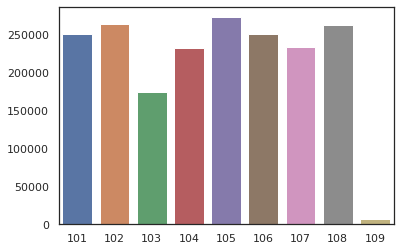

In [56]:
_ = sns.barplot(x=list(subjects.keys()), y=[subject.shape[0] for subject in subjects.values()])

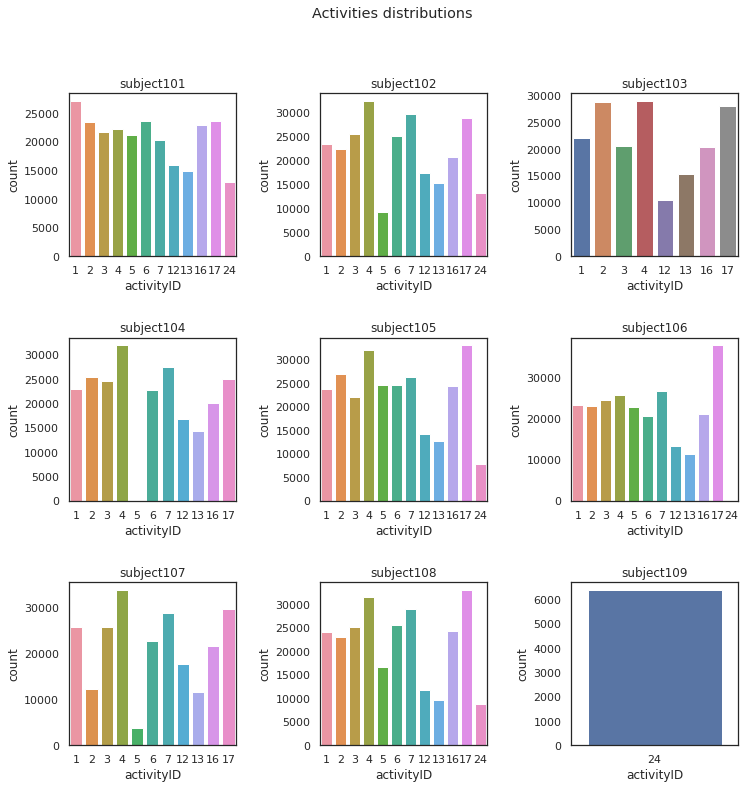

In [60]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,12))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle(f'Activities distributions')

for i in range(3):
    for j in range(3):
        curr_subject = i*3 + j + 1
        curr_subject = f'10{curr_subject}'
        subject_df = subjects[curr_subject]
        sns.countplot(x='activityID', data=subject_df, ax=ax[i][j])
        ax[i][j].set_title(f'subject{curr_subject}')

One intersting feature of this dataset is heart rate. Let's see how it varies depending on the activity.

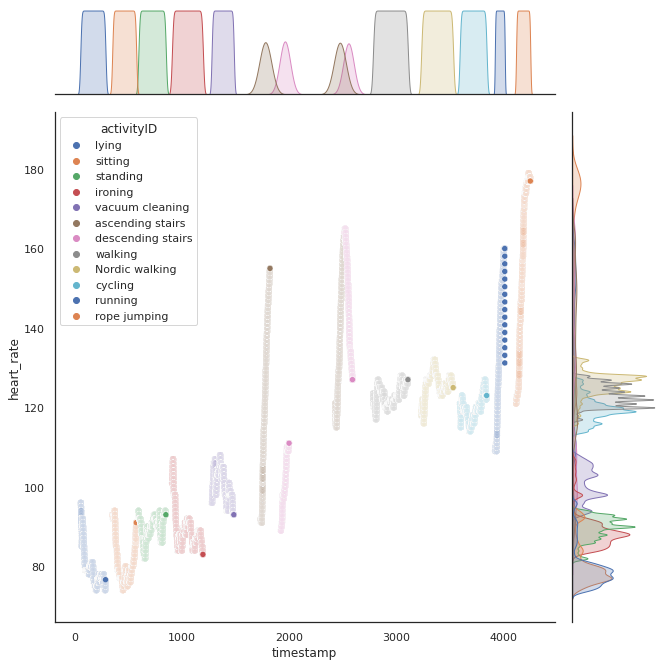

In [58]:
sns.set_theme(style='white')

# fig, ax = plt.subplots(figsize=(16,9))
joint = sns.jointplot(data=subjects['102'],
                x='timestamp', 
                y='heart_rate', 
                hue=subjects['102']['activityID'].map(id2activity), 
                palette='deep')
joint.fig.set_figwidth(10)
joint.fig.set_figheight(10)
# plt.show()

### Benchmarks

We identified several benchmark results torely on.



1.  [ Colegues from previous semester](https://www.kaggle.com/roylevy/pamap2-roy-yuval) class achieved 59.96% accuracy on the test set in their last attempt to build a LSTM model.
2.   [Another work](https://www.kaggle.com/avrahamcalev/time-series-models-pamap2-dataset) from previous semester achieved 92.54% accuracy on the test data, using a combination of LSTM, intermediate dense layers and dropout regularization.
3. 



### b. Explain the task at hand

We will define the task as a classification task.
Since the order of the activities is known beforehand there is no need to predict the future activity given the past or the other way around.
We will divide the samples into time series, each record will have one unique activity.
Our mission will be, given the measurements, to predict the activity. 

### c. State self-supervised tasks 

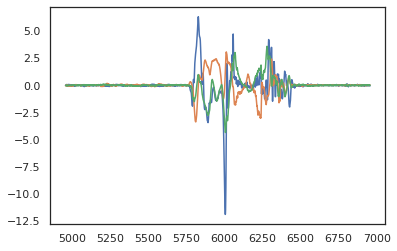

In [76]:
d = subjects['102'][:2000]
# _ = plt.plot(d['heart_rate'])
# _ = plt.plot(d['IMU_hand2'])
# _ = plt.plot(d['IMU_hand3'])
# _ = plt.plot(d['IMU_hand4'])
_ = plt.plot(d['IMU_hand8'])
_ = plt.plot(d['IMU_hand9'])
_ = plt.plot(d['IMU_hand10'])

1. 
2. task2

# 2. Forming neural network

### a. The validation strategy 

We have data regarding 9 subjects. As stated in the assignment specification, subjects 107, 108 will be used as our test set. For validation set will will use another two random subjects. It is convinient and easy to understand, and ressembles the test set.

In [132]:
sbjcts = list(subjects.keys())
val_size = 2

test_subjects = ['107', '108']

val_subjects = random.sample([sbj for sbj in sbjcts if sbj not in test_subjects], val_size)

train_subjects = [sbj for sbj in sbjcts if sbj not in test_subjects+val_subjects]

print('train subjects:\t\t', " ".join(train_subjects))
print('validation subjects:\t', " ".join(val_subjects))
print('test subjects:\t\t', " ".join(test_subjects))

train_subjects_df = {subject: subjects[subject] for subject in train_subjects}
val_subjects_df = {subject: subjects[subject] for subject in val_subjects}
test_subjects_df = {subject: subjects[subject] for subject in test_subjects}

train subjects:		 101 102 103 104 105
validation subjects:	 106 109
test subjects:		 107 108


IMU_chest1 < 33 ==> 5 or 24

In [144]:
subjects['102'].groupby('activityID').describe()['IMU_hand3']

,count,mean,std,min,25%,50%,75%,max
activityID,,,,,,,,
1,23430.0,2.959570,1.220261,-13.77890,2.552970,2.747350,3.089090,22.6620
2,22345.0,6.543119,3.064180,-37.46800,6.394230,6.875240,7.404930,85.7169
3,25576.0,4.636980,0.863597,-4.66519,4.522150,4.709590,4.938248,22.2126
4,32533.0,3.403753,2.452427,-8.97564,1.704610,2.912890,5.161680,16.8383
5,9238.0,10.064661,11.599960,-14.55660,2.222787,8.024235,16.919675,47.3080
6,25108.0,3.358299,2.550166,-19.64080,1.792610,3.340590,4.904167,41.7201
7,29739.0,5.970547,4.284898,-14.11940,3.690085,5.490390,7.599135,71.1042
12,17342.0,3.949408,2.847738,-50.02990,2.313135,3.375850,5.474118,33.4660
13,15213.0,3.969248,3.555074,-17.06620,2.229710,3.631280,5.649090,34.2675
